In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_csv("churn.csv")
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0004-TLHLJ,Male,50.0,No,0.0,Costa Mesa,92627.0,33.645672,-117.922613,0.0,...,Bank Withdrawal,73.9,280.85,0.0,0.0,134.60,415.45,Churned,Competitor,Competitor had better devices
1,0011-IGKFF,Male,78.0,Yes,0.0,Martinez,94553.0,38.014457,-122.115432,1.0,...,Bank Withdrawal,98.0,1237.85,0.0,0.0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
2,0013-EXCHZ,Female,75.0,Yes,0.0,Camarillo,93010.0,34.227846,-119.079903,3.0,...,Credit Card,83.9,267.40,0.0,0.0,22.14,289.54,Churned,Dissatisfaction,Network reliability
3,0022-TCJCI,Male,79.0,No,0.0,Daly City,94015.0,37.680844,-122.481310,0.0,...,Credit Card,62.7,2791.50,0.0,0.0,480.15,3271.65,Churned,Dissatisfaction,Limited range of services
4,0023-HGHWL,Male,67.0,No,0.0,Morgan Hill,95037.0,37.161544,-121.649371,0.0,...,Bank Withdrawal,25.1,25.10,0.0,0.0,0.00,25.10,Churned,Competitor,Competitor made better offer


In [8]:
selected_cols = {'Gender': 'gender',                    # binary categorical column -> can simply mapping
                 'Payment Method': 'payment_method',    # categorical column -> need encoder
                 'Age': 'age',                          # numerical column -> need scaler
                 'Avg Monthly GB Download': 'download', # numerical column -> need imputer, need scaler
                 'Monthly Charge': 'charge',            # numerical column -> need scaler
                 'Customer Status': 'status'            # label
                 }
df = df[selected_cols.keys()]
df = df.rename(columns=selected_cols)
df = df.dropna(subset=['status'])
print(df.shape)
df.head()

(6590, 6)


,gender,payment_method,age,download,charge,status
0,Male,Bank Withdrawal,50.0,30.0,73.9,Churned
1,Male,Bank Withdrawal,78.0,4.0,98.0,Churned
2,Female,Credit Card,75.0,11.0,83.9,Churned
3,Male,Credit Card,79.0,17.0,62.7,Churned
4,Male,Bank Withdrawal,67.0,9.0,25.1,Churned


In [9]:
# check missing values
df.isna().sum()

gender               1
payment_method       1
age                  1
download          1345
charge               1
status               0
dtype: int64

In [10]:
# check if the missing data on 'gender', 'payment_method', 'age', 'charge' are at the same record
df[df['gender'].isna()]

,gender,payment_method,age,download,charge,status
6589,NaN,NaN,NaN,NaN,NaN,Stayed


In [11]:
# drop the records that misses everything
df = df.dropna(subset=['gender', 'payment_method', 'age', 'charge'], how='all')

In [12]:
# check missing value on 'download'
df[df['download'].isna()].head()

,gender,payment_method,age,download,charge,status
6,Female,Credit Card,34.0,NaN,20.35,Churned
11,Male,Bank Withdrawal,32.0,NaN,19.85,Churned
21,Female,Credit Card,24.0,NaN,19.85,Churned
29,Male,Bank Withdrawal,62.0,NaN,25.30,Churned
42,Female,Bank Withdrawal,41.0,NaN,19.75,Churned


# Let's processing

In [13]:
def prep_gender(df):
    mapping = {
        'Female': 0,
        'Male': 1
    }
    df = df.copy()
    df['gender'] = df['gender'].map(mapping).astype(int)
    return df

def prep_customer_status(df):
    mapping = {
        'Churned': 1,
        'Stayed': 0
    }
    df = df.copy()
    if 'status' in df.columns:
        df['status'] = df['status'].map(mapping).astype(int)
    return df

def prep_payment_method(df, encoder=None):
    df = df.copy()
    cols = ['payment_method']
    df_target = df[cols]
    if encoder is None:
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoder.fit(df_target)
    encoded = encoder.transform(df_target)
    df_encoded = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cols))
    df_encoded = df_encoded.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df_transformed = pd.concat([df, df_encoded], axis=1)
    df_transformed = df_transformed.drop(cols, axis=1)
    return df_transformed, encoder

def scale_num_cols(df, scaler=None):
    df = df.copy()
    cols = ['age', 'download', 'charge']
    df_target = df[cols]
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(df_target)
    df_target = scaler.transform(df_target)
    df[cols] = df_target
    return df, scaler

def impute_missing(df, imputer=None):
    df = df.copy()
    cols = ['download']
    df_target = df[cols]
    if imputer is None:
        imputer = SimpleImputer(strategy='mean')
        imputer.fit(df_target)
    df_target = imputer.transform(df_target)
    df[cols] = df_target
    return df, imputer
    

def preprocessing(df, artifacts={}):
    # take everything
    df = df.copy()
    df = prep_gender(df)
    df = prep_customer_status(df)
    if not artifacts:
        df, encoder = prep_payment_method(df)
        df, scaler = scale_num_cols(df)
        df, imputer = impute_missing(df)
        artifacts = {
            'encoder': encoder,
            'scaler': scaler,
            'imputer': imputer
        }
    else:
        df, _ = prep_payment_method(df, artifacts['encoder'])
        df, _ = scale_num_cols(df, artifacts['scaler'])
        df, _ = impute_missing(df, artifacts['imputer'])
    return df, artifacts


In [14]:
# Before any data processing, split train/test set
df_train, df_test = train_test_split(
                            df,
                            test_size=0.2,
                            random_state=46
                            )

In [15]:
df_train_prep, artifacts = preprocessing(df_train)
df_train_prep.head()

,gender,age,download,charge,status,payment_method_Bank Withdrawal,payment_method_Credit Card,payment_method_Mailed Check
0,0,0.893130,-4.608931e-01,0.319483,0,1.0,0.0,0.0
1,0,-0.835446,-3.987047e-17,-1.293997,0,1.0,0.0,0.0
2,0,0.535493,-3.987047e-17,-1.308432,0,0.0,1.0,0.0
3,1,-0.835446,-7.707613e-01,0.675539,1,1.0,0.0,0.0
4,0,-0.835446,-3.987047e-17,-1.279563,0,0.0,1.0,0.0


In [16]:
df_train_prep.isna().sum()

gender                            0
age                               0
download                          0
charge                            0
status                            0
payment_method_Bank Withdrawal    0
payment_method_Credit Card        0
payment_method_Mailed Check       0
dtype: int64

In [17]:
df_test_prep, _ = preprocessing(df_test, artifacts)
df_test_prep.head()

,gender,age,download,charge,status,payment_method_Bank Withdrawal,payment_method_Credit Card,payment_method_Mailed Check
0,1,0.595099,-1.080629e+00,-0.423103,1,1.0,0.0,0.0
1,1,0.058645,-1.028985e+00,0.139851,1,1.0,0.0,0.0
2,1,-0.179779,-3.059591e-01,-0.937941,0,0.0,1.0,0.0
3,1,-0.239385,-3.987047e-17,-1.454383,1,0.0,0.0,1.0
4,0,0.773918,-7.707613e-01,0.117397,0,1.0,0.0,0.0


In [18]:
df_test_prep.isna().sum()

gender                            0
age                               0
download                          0
charge                            0
status                            0
payment_method_Bank Withdrawal    0
payment_method_Credit Card        0
payment_method_Mailed Check       0
dtype: int64

# Train model

In [19]:
from sklearn.ensemble import RandomForestClassifier
X_train = df_train_prep.drop(columns=['status'])
X_test = df_test_prep.drop(columns=['status'])

y_train = df_train_prep['status']
y_test = df_test_prep['status']


clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)


Accuracy: 0.9992411307152343
F1_score: 0.998671096345515


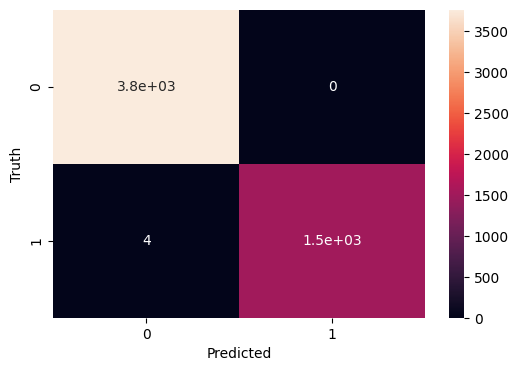

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

cm = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

print(f"Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"F1_score: {f1_score(y_train, y_pred_train)}")


Accuracy: 0.6843702579666161
F1_score: 0.3202614379084967


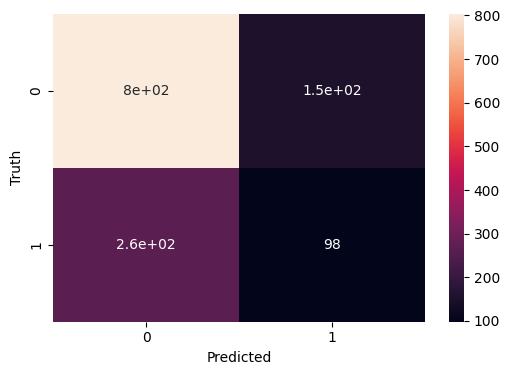

In [21]:
cm = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize = (6,4))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(f"Accuracy: {accuracy_score(y_test, y_pred_test)}")
print(f"F1_score: {f1_score(y_test, y_pred_test)}")

In [23]:
# export all necessary components
import pickle
import os
from pathlib import Path

def write_artifacts(variable, filename):
    parent = Path(filename).parent
    parent.mkdir(parents=True, exist_ok=True)
    with open(filename, 'wb') as f:
        pickle.dump(variable, f)

artifacts_dir = Path('artifacts/')
artifacts_file = artifacts_dir / "artifacts.pkl" 
# windows: artifacts\artifacts.pkl
# linux/mac: artifacts/artifacts.pkl
model_file = artifacts_dir / "model.pkl"
# windows: artifacts\model.pkl
# linux/mac: artifacts/model.pkl

write_artifacts(artifacts, artifacts_file)
write_artifacts(clf, model_file)
